In [16]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix


In [5]:
from google.colab import drive
drive.mount('/content/drive')
adni = pd.read_csv('/content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI1_Annual_2_Yr_3T_7_22_2024.csv', sep=',')
adni.drop(adni.columns[5:8], axis=1, inplace=True)
adni.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Image Data ID,Subject,Group,Sex,Age,Type,Acq Date,Format,Downloaded
0,I143856,136_S_1227,MCI,F,67,Processed,3/23/2009,NiFTI,6/10/2024
1,I99265,136_S_1227,MCI,F,66,Processed,3/06/2008,NiFTI,6/10/2024
2,I66824,136_S_1227,MCI,F,65,Processed,2/21/2007,NiFTI,6/10/2024
3,I120618,136_S_0579,MCI,F,68,Processed,8/18/2008,NiFTI,6/10/2024
4,I40404,136_S_0579,MCI,F,66,Processed,7/10/2006,NiFTI,6/10/2024


In [18]:
base_directory = '/content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI1_Annual'
destination_directory = '/content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI_Separado'


#Função para encontrar a pasta correspondente à ID
def find_folder(base_dir, image_id):
    for root, dirs, files in os.walk(base_dir):
        for folder in dirs:
            if folder == image_id:
                return os.path.join(root, folder)
    return None

# Função para converter .nii para .png
def nii_to_png(nii_file_path, png_file_path):
    # Carrega o arquivo .nii
    img = nib.load(nii_file_path)
    data = img.get_fdata()

    # Converte cada fatia do volume em uma imagem PNG
    num_slices = data.shape[2]
    for i in range(num_slices):
        slice_data = data[:, :, i]
        plt.imshow(slice_data, cmap='gray')
        plt.axis('off')
        plt.savefig(f"{png_file_path}_{i}.png", bbox_inches='tight', pad_inches=0)
        plt.close()

# Função para copiar a pasta para o destino
def copy_folder(source, destination):
    if not os.path.exists(destination):
        shutil.copytree(source, destination)
    else:
        print(f"A pasta {destination} já existe e não será sobrescrita.")

# Processa cada linha do DataFrame
for _, row in adni.iterrows():
    image_id = row['Image Data ID']
    group = row['Group']

    # Encontra a pasta correspondente
    source_folder = find_folder(base_directory, image_id)
    if source_folder is None:
        print(f"Pasta para ID {image_id} não encontrada.")
        continue

    # Converte arquivos .nii para .png
    for file_name in os.listdir(source_folder):
        if file_name.endswith('.nii'):
            nii_file_path = os.path.join(source_folder, file_name)
            png_file_path = os.path.join(source_folder, os.path.splitext(file_name)[0])
            nii_to_png(nii_file_path, png_file_path)

    # Define o destino com base na classificação do grupo
    destination_folder = os.path.join(destination_directory, group, image_id)

    # Copia a pasta
    copy_folder(source_folder, destination_folder)
    print(f"Pasta {source_folder} copiada para {destination_folder}")

print("Processamento concluído.")

Pasta /content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI1_Annual/ADNI/136_S_1227/MPR____N3__Scaled/2009-03-23_11_59_29.0/I143856 copiada para /content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI_Separado/MCI/I143856
Pasta para ID I99265 não encontrada.
Pasta para ID I66824 não encontrada.
Pasta para ID I120618 não encontrada.
Pasta /content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI1_Annual/ADNI/136_S_0579/MPR-R____N3__Scaled/2006-07-10_11_45_57.0/I40404 copiada para /content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI_Separado/MCI/I40404
Pasta para ID I119735 não encontrada.
Pasta para ID I83554 não encontrada.
Pasta para ID I83549 não encontrada.
Pasta para ID I40392 não encontrada.
Pasta para ID I119733 não encontrada.
Pasta para ID I120446 não encontrada.
Pasta para ID I40378 não encontrada.
Pasta /content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI1_Annual/ADNI/136_S_0426/MPR____N3__Scaled/2007-06-04_12_24_17.0/I66787 copiada para /content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI_Separado/AD/I66787
Pasta

In [6]:
# Configurações
destination_directory = '/content/drive/MyDrive/ADNI_ML/ADNI_ML_GIT/ADNI_Separado'
image_size = (128, 128)  # Tamanho das imagens após o redimensionamento
batch_size = 32


In [7]:
# Cria geradores de dados para treinamento e validação
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Divide os dados em 80% treinamento e 20% validação
    horizontal_flip=True,  # Aumenta os dados com espelhamento horizontal
    rotation_range=20,     # Rotaciona as imagens aleatoriamente
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    destination_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 3965 images belonging to 3 classes.


In [9]:
validation_generator = train_datagen.flow_from_directory(
    destination_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 991 images belonging to 3 classes.


In [10]:
# Cria o modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compila o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Treina o modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
124/124 [==============================] - 189s 2s/step - loss: 0.9525 - accuracy: 0.5137 - val_loss: 1.8573 - val_accuracy: 0.2371
Epoch 2/10
124/124 [==============================] - 184s 1s/step - loss: 0.6148 - accuracy: 0.7407 - val_loss: 2.8333 - val_accuracy: 0.1231
Epoch 3/10
124/124 [==============================] - 195s 2s/step - loss: 0.4295 - accuracy: 0.8242 - val_loss: 3.9116 - val_accuracy: 0.1261
Epoch 4/10
124/124 [==============================] - 184s 1s/step - loss: 0.2775 - accuracy: 0.8943 - val_loss: 5.6004 - val_accuracy: 0.1695
Epoch 5/10
124/124 [==============================] - 183s 1s/step - loss: 0.1851 - accuracy: 0.9299 - val_loss: 5.9480 - val_accuracy: 0.1847
Epoch 6/10
124/124 [==============================] - 187s 2s/step - loss: 0.1501 - accuracy: 0.9427 - val_loss: 7.2665 - val_accuracy: 0.1746
Epoch 7/10
124/124 [==============================] - 202s 2s/step - loss: 0.1198 - accuracy: 0.9584 - val_loss: 6.9788 - val_accuracy: 0.1524

In [12]:
# Avalia o modelo
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Perda no teste: {test_loss}")
print(f"Acurácia no teste: {test_acc}")

31/31 [==============================] - 25s 784ms/step - loss: 9.6869 - accuracy: 0.1988
Perda no teste: 9.686942100524902
Acurácia no teste: 0.1987891048192978


31/31 [==============================] - 21s 685ms/step


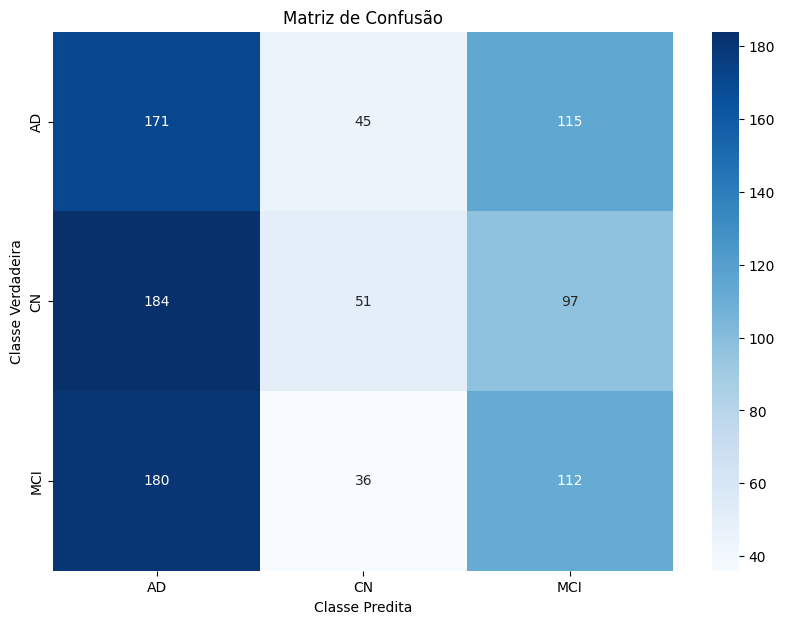

Desvio padrão das previsões: [0.4223892  0.28595752 0.4223892 ]
Desvio padrão da acurácia durante o treinamento: 0.13930713364384756


In [17]:
# Obtém as previsões do modelo
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtém os rótulos verdadeiros
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plota a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.title('Matriz de Confusão')
plt.show()

# Passo 3: Calcular o Desvio Padrão

# Calcula o desvio padrão das previsões
std_dev = np.std(predictions, axis=0)
print(f"Desvio padrão das previsões: {std_dev}")

# Se desejar calcular o desvio padrão da acurácia
accuracies = history.history['accuracy']
std_dev_acc = np.std(accuracies)
print(f"Desvio padrão da acurácia durante o treinamento: {std_dev_acc}")